In [3]:
import cv2

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import cv2

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Transforms (same as feature extraction)
# ----------------------------
normalize = transforms.Normalize((0.5,), (0.5,))

base_transform = transforms.Compose([
    transforms.ToTensor()
])

normalized_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    normalize
])

transform_variants = {
    "Base": base_transform,
    "Normalized": normalized_transform,
    "Augmented": augment_transform,
    "Regularized": augment_transform
}



In [6]:
# ----------------------------
# Simple CNN class with configurable dropout (dropout only used in classifier)
# ----------------------------
class LeNet(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.0):
        super(LeNet, self).__init__()
        
        # Convolutional layers (LeNet-style)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)   # input: 1x28x28 → 6x28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)                 # → 6x14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)             # → 16x10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)                 # → 16x5x5

        # Dropout layer (optional)
        self.dropout = nn.Dropout(dropout_prob) if dropout_prob > 0 else nn.Identity()

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # Feature extraction
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Classifier
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x




In [7]:
# ----------------------------
# Training & evaluation helpers
# ----------------------------
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    avg_loss = running_loss / len(loader)
    acc = 100.0 * correct / total
    return avg_loss, acc

def evaluate(model, loader, criterion=None):
    model.eval()
    preds_all, labels_all = [], []
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            if criterion is not None:
                total_loss += criterion(outputs, labels).item()
    loss = (total_loss / len(loader)) if (criterion is not None) else None
    acc = 100.0 * (np.array(preds_all) == np.array(labels_all)).mean()
    return acc, loss, np.array(preds_all), np.array(labels_all)



In [8]:
# ----------------------------
# Grad-CAM (uses last conv layer conv3)
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        self.model.zero_grad()
        out = self.model(input_tensor)
        if target_class is None:
            target_class = out.argmax(dim=1).item()
        one_hot = torch.zeros_like(out)
        one_hot[0, target_class] = 1
        out.backward(gradient=one_hot, retain_graph=True)

        grads = self.gradients        # BxCxhxw
        acts = self.activations      # BxCxhxw
        weights = grads.mean(dim=(2,3), keepdim=True)  # BxCx1x1
        cam = (weights * acts).sum(dim=1)              # Bxhxw
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, target_class




=== Running variant: Base ===
Epoch [1/10] Train Loss: 0.4751 Train Acc: 85.24% | Val Loss: 0.1780 Val Acc: 94.41%
Epoch [2/10] Train Loss: 0.1301 Train Acc: 96.02% | Val Loss: 0.1022 Val Acc: 96.65%
Epoch [3/10] Train Loss: 0.0885 Train Acc: 97.26% | Val Loss: 0.0692 Val Acc: 97.67%
Epoch [4/10] Train Loss: 0.0681 Train Acc: 97.88% | Val Loss: 0.0576 Val Acc: 98.06%
Epoch [5/10] Train Loss: 0.0566 Train Acc: 98.22% | Val Loss: 0.0676 Val Acc: 97.74%
Epoch [6/10] Train Loss: 0.0480 Train Acc: 98.50% | Val Loss: 0.0427 Val Acc: 98.67%
Epoch [7/10] Train Loss: 0.0423 Train Acc: 98.67% | Val Loss: 0.0441 Val Acc: 98.61%
Epoch [8/10] Train Loss: 0.0366 Train Acc: 98.82% | Val Loss: 0.0345 Val Acc: 98.85%
Epoch [9/10] Train Loss: 0.0323 Train Acc: 98.99% | Val Loss: 0.0373 Val Acc: 98.77%
Epoch [10/10] Train Loss: 0.0278 Train Acc: 99.07% | Val Loss: 0.0359 Val Acc: 98.84%
Final Test Acc: 98.84%  Prec: 0.9885 Rec: 0.9881 F1: 0.9883
Classification report:
               precision    recall 

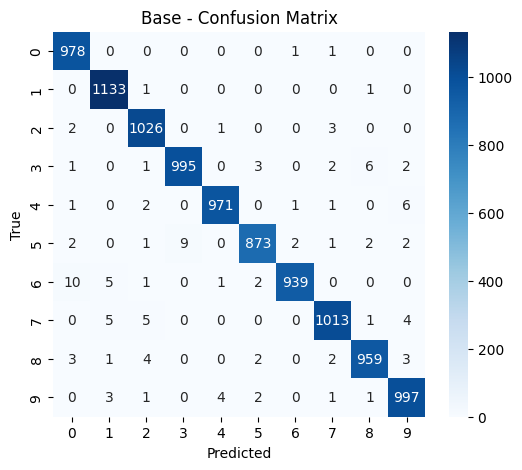

/tmp/ipykernel_50251/1889912173.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


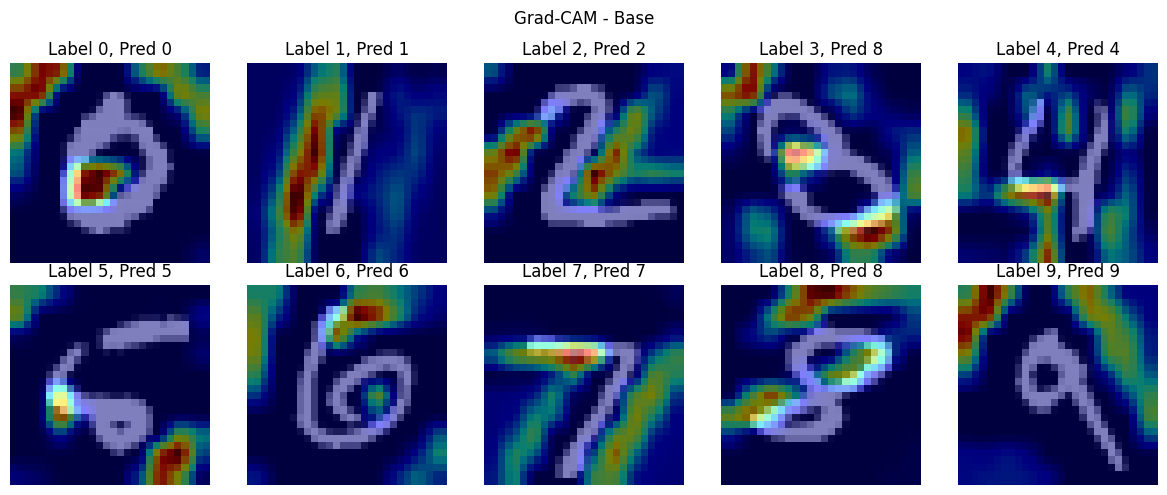


=== Running variant: Normalized ===
Epoch [1/10] Train Loss: 0.4304 Train Acc: 86.83% | Val Loss: 0.1282 Val Acc: 95.92%
Epoch [2/10] Train Loss: 0.1061 Train Acc: 96.77% | Val Loss: 0.0729 Val Acc: 97.51%
Epoch [3/10] Train Loss: 0.0719 Train Acc: 97.78% | Val Loss: 0.0584 Val Acc: 98.06%
Epoch [4/10] Train Loss: 0.0563 Train Acc: 98.22% | Val Loss: 0.0417 Val Acc: 98.63%
Epoch [5/10] Train Loss: 0.0476 Train Acc: 98.56% | Val Loss: 0.0458 Val Acc: 98.52%
Epoch [6/10] Train Loss: 0.0408 Train Acc: 98.71% | Val Loss: 0.0373 Val Acc: 98.78%
Epoch [7/10] Train Loss: 0.0353 Train Acc: 98.92% | Val Loss: 0.0375 Val Acc: 98.79%
Epoch [8/10] Train Loss: 0.0318 Train Acc: 99.03% | Val Loss: 0.0281 Val Acc: 99.11%
Epoch [9/10] Train Loss: 0.0274 Train Acc: 99.13% | Val Loss: 0.0279 Val Acc: 99.08%
Epoch [10/10] Train Loss: 0.0238 Train Acc: 99.25% | Val Loss: 0.0387 Val Acc: 98.76%
Final Test Acc: 98.76%  Prec: 0.9876 Rec: 0.9875 F1: 0.9875
Classification report:
               precision    r

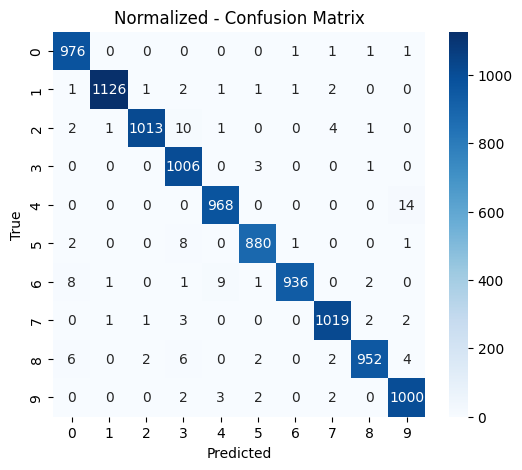

/tmp/ipykernel_50251/1889912173.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


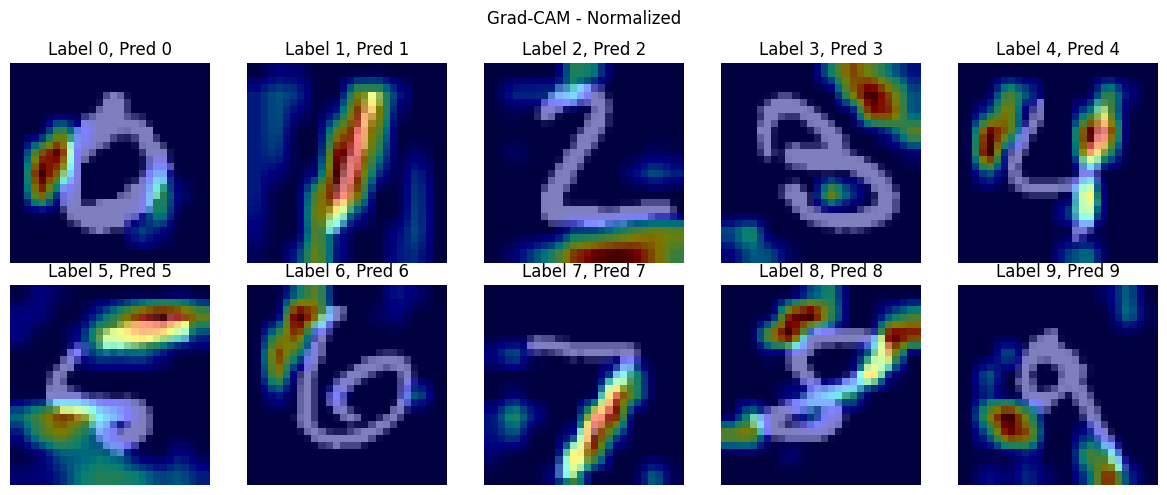


=== Running variant: Augmented ===
Epoch [1/10] Train Loss: 0.6998 Train Acc: 76.79% | Val Loss: 0.3239 Val Acc: 89.40%
Epoch [2/10] Train Loss: 0.2697 Train Acc: 91.38% | Val Loss: 0.2006 Val Acc: 93.88%
Epoch [3/10] Train Loss: 0.1905 Train Acc: 94.06% | Val Loss: 0.1567 Val Acc: 94.78%
Epoch [4/10] Train Loss: 0.1503 Train Acc: 95.33% | Val Loss: 0.1490 Val Acc: 95.32%
Epoch [5/10] Train Loss: 0.1334 Train Acc: 95.76% | Val Loss: 0.1282 Val Acc: 95.94%
Epoch [6/10] Train Loss: 0.1166 Train Acc: 96.26% | Val Loss: 0.0919 Val Acc: 97.01%
Epoch [7/10] Train Loss: 0.1037 Train Acc: 96.70% | Val Loss: 0.0954 Val Acc: 97.00%
Epoch [8/10] Train Loss: 0.0961 Train Acc: 96.99% | Val Loss: 0.0877 Val Acc: 97.02%
Epoch [9/10] Train Loss: 0.0899 Train Acc: 97.13% | Val Loss: 0.0832 Val Acc: 97.19%
Epoch [10/10] Train Loss: 0.0865 Train Acc: 97.25% | Val Loss: 0.0834 Val Acc: 97.25%
Final Test Acc: 97.21%  Prec: 0.9723 Rec: 0.9714 F1: 0.9717
Classification report:
               precision    re

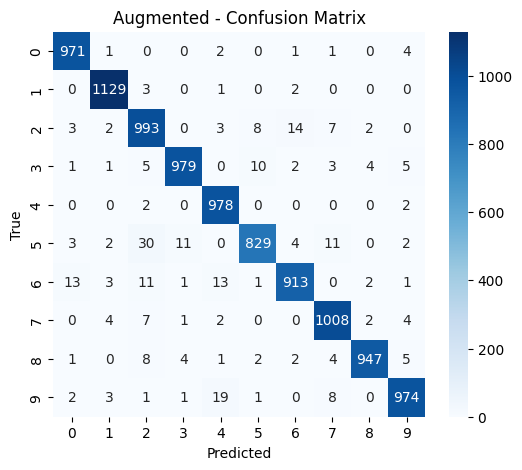

/tmp/ipykernel_50251/1889912173.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


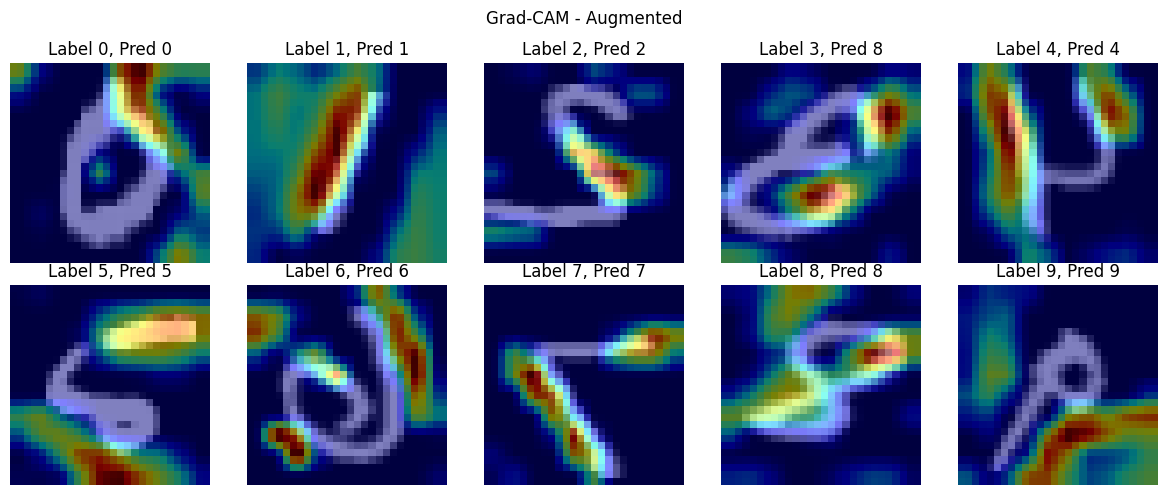


=== Running variant: Regularized ===
Epoch [1/10] Train Loss: 1.0734 Train Acc: 63.19% | Val Loss: 0.4440 Val Acc: 85.94%
Epoch [2/10] Train Loss: 0.5498 Train Acc: 81.97% | Val Loss: 0.2964 Val Acc: 89.94%
Epoch [3/10] Train Loss: 0.4232 Train Acc: 86.66% | Val Loss: 0.2153 Val Acc: 93.13%
Epoch [4/10] Train Loss: 0.3545 Train Acc: 88.95% | Val Loss: 0.1891 Val Acc: 94.37%
Epoch [5/10] Train Loss: 0.3100 Train Acc: 90.75% | Val Loss: 0.1500 Val Acc: 95.40%
Epoch [6/10] Train Loss: 0.2807 Train Acc: 91.70% | Val Loss: 0.1438 Val Acc: 95.72%
Epoch [7/10] Train Loss: 0.2568 Train Acc: 92.44% | Val Loss: 0.1314 Val Acc: 96.00%
Epoch [8/10] Train Loss: 0.2402 Train Acc: 93.00% | Val Loss: 0.1083 Val Acc: 96.57%
Epoch [9/10] Train Loss: 0.2248 Train Acc: 93.39% | Val Loss: 0.1156 Val Acc: 96.28%
Epoch [10/10] Train Loss: 0.2140 Train Acc: 93.70% | Val Loss: 0.1011 Val Acc: 96.92%
Final Test Acc: 96.76%  Prec: 0.9670 Rec: 0.9672 F1: 0.9670
Classification report:
               precision    

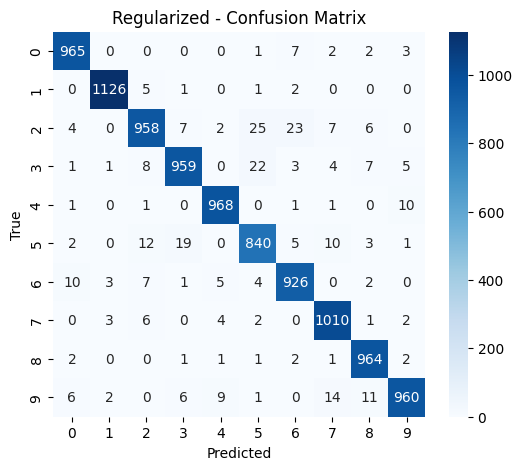

/tmp/ipykernel_50251/1889912173.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


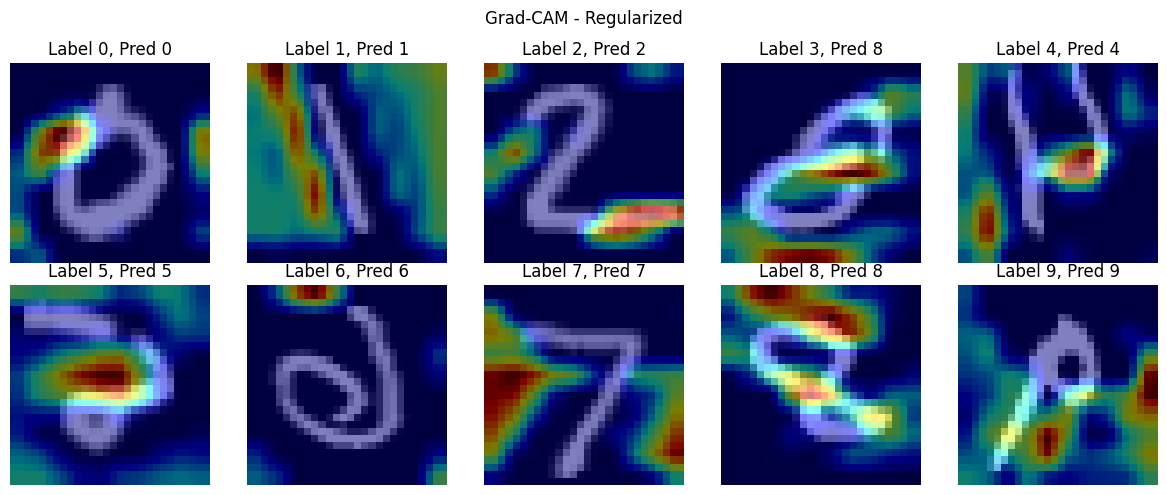

In [10]:
# ----------------------------
# Main loop: training all variations properly (dropout + weight_decay only for Regularized)
# ----------------------------
results = {}
num_epochs = 10
batch_size = 128
criterion = nn.CrossEntropyLoss()

for name, transform in transform_variants.items():
    print(f"\n=== Running variant: {name} ===")
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=1000, shuffle=False)

    # regularize logic: enable dropout in model and weight decay in optimizer only for 'Regularized'
    is_regularize = (name == "Regularized")
    dropout_prob = 0.5 if is_regularize else 0.0

    model = LeNet(num_classes=10, dropout_prob=dropout_prob).to(device)

    weight_decay = 1e-4 if is_regularize else 0.0
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)

    # History containers
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Train
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_acc, val_loss, _, _ = evaluate(model, test_loader, criterion)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")

    # Final evaluation metrics (detailed)
    test_acc, _, preds, labels = evaluate(model, test_loader)
    prec = precision_score(labels, preds, average='macro')
    rec  = recall_score(labels, preds, average='macro')
    f1   = f1_score(labels, preds, average='macro')
    print(f"Final Test Acc: {test_acc:.2f}%  Prec: {prec:.4f} Rec: {rec:.4f} F1: {f1:.4f}")
    print("Classification report:\n", classification_report(labels, preds, digits=4))

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Grad-CAM: visualize one example per class (2x5 grid)
    gradcam = GradCAM(model, model.conv2)
    fig, axes = plt.subplots(2, 5, figsize=(12,5))
    axes_flat = axes.flatten()
    for i in range(10):
        idx = np.where(np.array(test_ds.targets) == i)[0][0]
        img, _ = test_ds[idx]
        inp = img.unsqueeze(0).to(device)
        inp.requires_grad_()
        cam, cls = gradcam.generate(inp)
        cam_resized = cv2.resize(cam, (img.shape[2], img.shape[1]))
        ax = axes_flat[i]
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.imshow(cam_resized, cmap='jet', alpha=0.5)
        ax.set_title(f"Label {i}, Pred {cls}")
        ax.axis("off")
    plt.suptitle(f"Grad-CAM - {name}")
    plt.tight_layout()
    plt.show()

    # store results
    results[name] = {"history": history, "test_acc": test_acc, "prec": prec, "rec": rec, "f1": f1, "cm": cm}



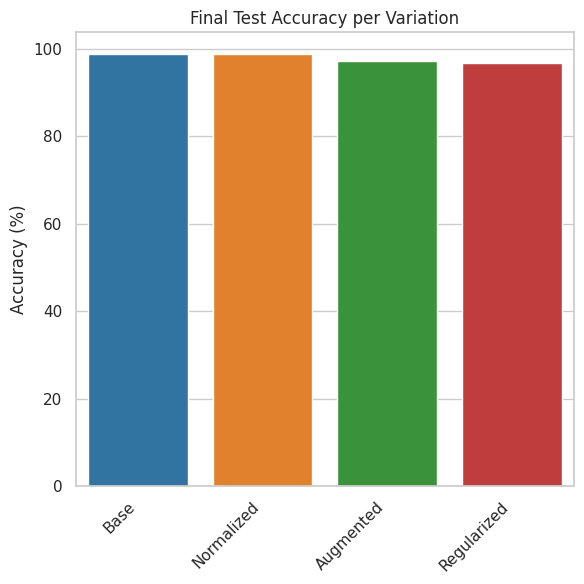

In [11]:
# Summary bar chart (final test accuracy)
import pandas as pd
names = list(results.keys())
accs  = [results[n]["test_acc"] for n in names]
df = pd.DataFrame({
    'Variation': names,
    'Accuracy': accs
})

plt.figure(figsize=(6,6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=df,
    x='Variation',
    y='Accuracy',
    hue='Variation',
    dodge=False,
    palette='tab10',
    legend=False
)

ax.set_title("Final Test Accuracy per Variation")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel(None)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

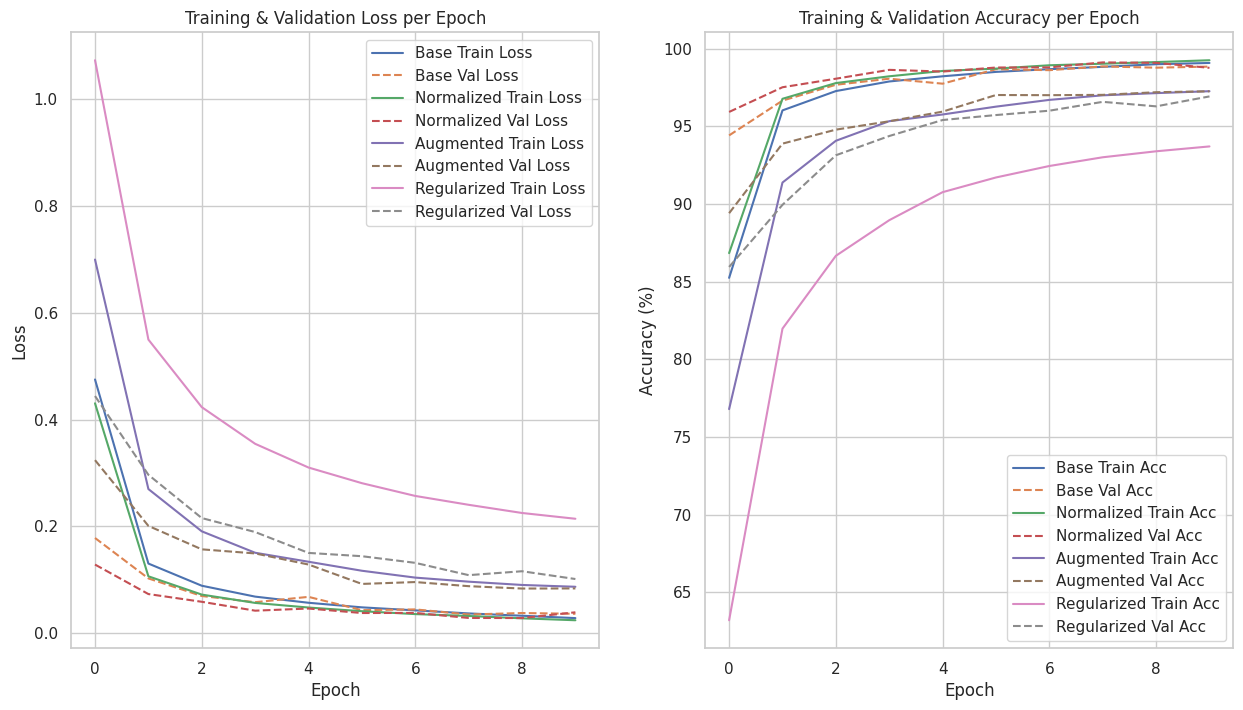

In [12]:
# ----------------------------
# Plot loss & accuracy curves for all variants
# ----------------------------
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)

for name, res in results.items():
    history = res["history"]
    plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.plot(history["val_loss"], linestyle="--", label=f"{name} Val Loss")

plt.title("Training & Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
# plt.show()

# Plot accuracy curves
plt.subplot(1,2,2)
for name, res in results.items():
    history = res["history"]
    plt.plot(history["train_acc"], label=f"{name} Train Acc")
    plt.plot(history["val_acc"], linestyle="--", label=f"{name} Val Acc")

plt.title("Training & Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import pickle

with open("results_cnnbaseline.pkl", "wb") as f:
    pickle.dump(results, f)


In [ ]:
with open("./results_cnnbaseline.pkl", "rb") as f:
    results= pickle.load(f)

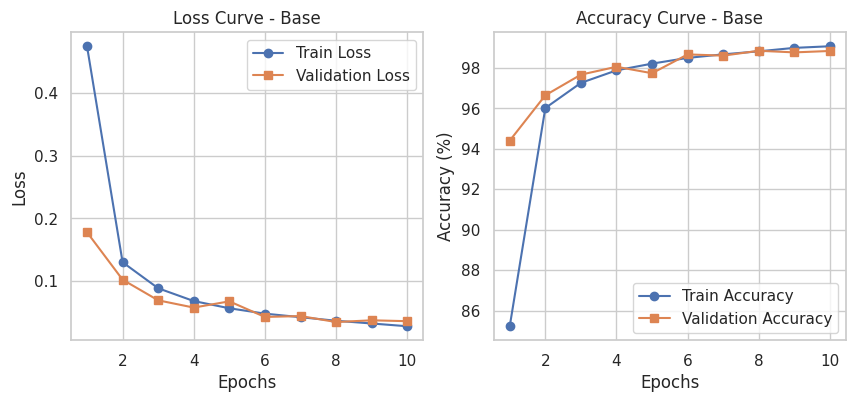

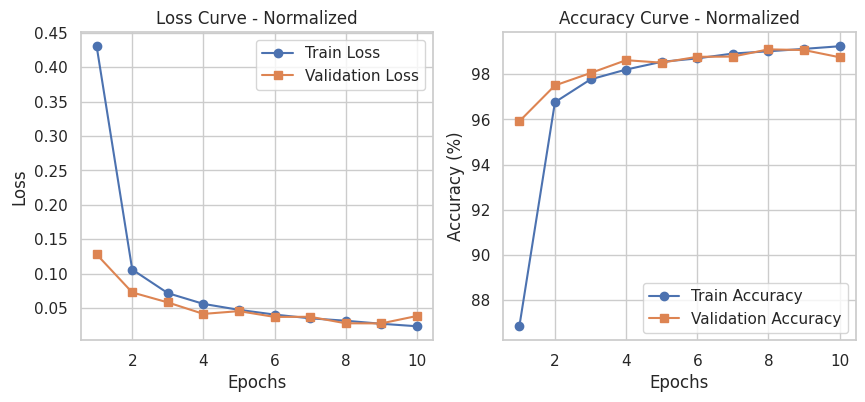

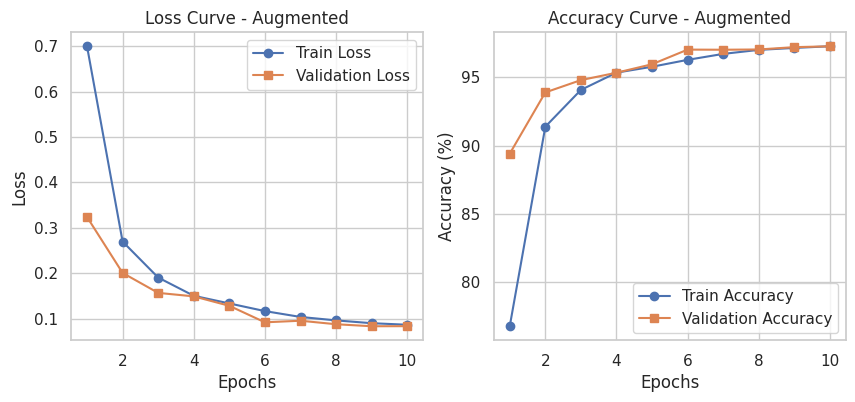

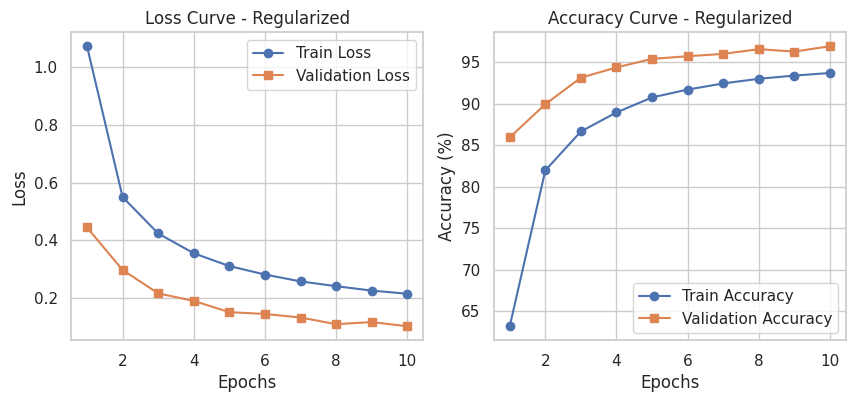

In [14]:
for variation, data in results.items():
    if "history" not in data:
        continue
    
    history = data["history"]
    epochs = range(1, len(history["train_loss"]) + 1)

    # --- LOSS CURVE ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='s')
    plt.title(f"Loss Curve - {variation}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # --- ACCURACY CURVE ---
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker='o')
    plt.plot(epochs, [float(v) for v in history["val_acc"]], label="Validation Accuracy", marker='s')
    plt.title(f"Accuracy Curve - {variation}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()